# 输入-输出模型
## 概述
在我们继续之前，本讲座需要以下导入和安装。

In [1]:
!pip install quantecon_book_networks
!pip install quantecon
!pip install pandas-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.8/364.8 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.8/867.8 kB 78.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import quantecon_book_networks
import quantecon_book_networks.input_output as qbn_io
import quantecon_book_networks.plotting as qbn_plt
import quantecon_book_networks.data as qbn_data
import matplotlib as mpl
from matplotlib.patches import Polygon

quantecon_book_networks.config("matplotlib")
mpl.rcParams.update(mpl.rcParamsDefault)

FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

下图展示了从美国经济分析局2021年输入-输出账户数据中获得的15个部门之间的联系网络。

In [3]:
def build_coefficient_matrices(Z, X):
    """
   通过以下方式从Z和X构建系数矩阵A和F：

        A[i, j] = Z[i, j] / X[j]
        F[i, j] = Z[i, j] / X[i]

    """
    A, F = np.empty_like(Z), np.empty_like(Z)
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            A[i, j] = Z[i, j] / X[j]
            F[i, j] = Z[i, j] / X[i]

    return A, F

ch2_data = qbn_data.production()
codes = ch2_data["us_sectors_15"]["codes"]
Z = ch2_data["us_sectors_15"]["adjacency_matrix"]
X = ch2_data["us_sectors_15"]["total_industry_sales"]
A, F = build_coefficient_matrices(Z, X)

/home/runner/miniconda3/envs/quantecon/lib/python3.11/site-packages/quantecon_book_networks/data.py:434: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  gdp_df = wb.download(indicator=varlist, country=c, start=s, end=e)


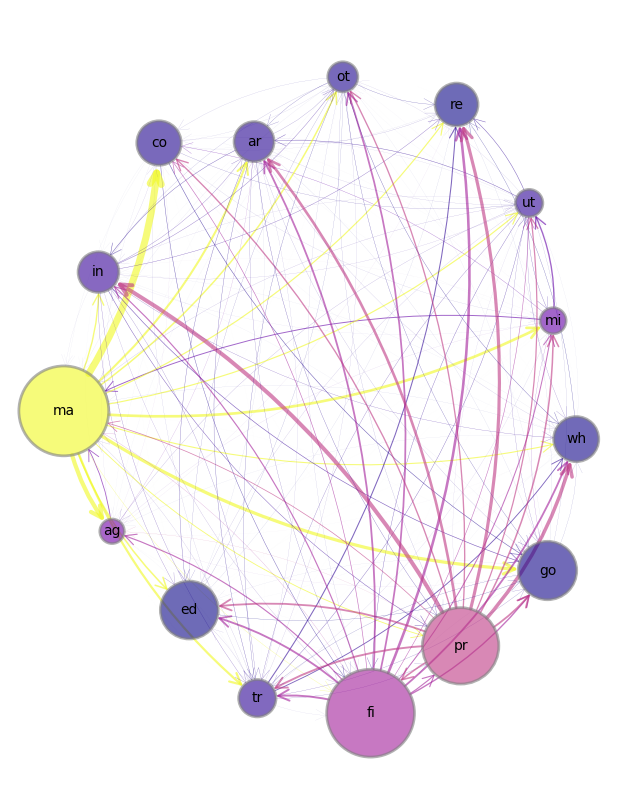

In [4]:
centrality = qbn_io.eigenvector_centrality(A)

# 去掉自循环
for i in range(A.shape[0]):
    A[i][i] = 0

fig, ax = plt.subplots(figsize=(8, 10))
plt.axis("off")
color_list = qbn_io.colorise_weights(centrality,beta=False)

qbn_plt.plot_graph(A, X, ax, codes,
              layout_type='spring',
              layout_seed=5432167,
              tol=0.0,
              node_color_list=color_list)

plt.show()

|标签| 行业 |标签| 行业 |标签| 行业 |
|:---:|:-------------:|:---:|:--------------:|:---:|:-------------------------:|
| ag  | 农业 | wh  | 批发 | pr  | 专业服务 |
| mi  | 采矿业 | re  | 零售 | ed  | 教育与健康 |
| ut  | 公用事业 | tr  | 运输 | ar  | 艺术与娱乐 |
| co  | 建筑 | in  | 信息 | ot  | 其他服务（不包括政府） |
| ma  | 制造业 | fi  | 金融 | go  | 政府 |

从$i$到$j$的箭头表示$i$行业的一些产出作为$j$行业生产的输入。

经济的特征是存在许多这样的联系。

分析这些联系的基本框架是[列昂惕夫](https://en.wikipedia.org/wiki/Wassily_Leontief)的投入产出模型。

在介绍投入产出模型之后，我们将描述它与{doc}`线性规划讲座 <lp_intro>`的一些联系。

## 投入产出分析

设
 * $x_0$为单一外生生产投入的数量，例如劳动力
 * $x_j, j = 1,\ldots n$为最终产品$j$的总产出
 * $d_j, j = 1,\ldots n$为可用于最终消费的最终产品$j$的净产出
 * $z_{ij}$为分配用作生产产品$j$的投入的产品$i$的数量，$i=1, \ldots n$，$j = 1, \ldots n$
 * $z_{0j}$为分配用于生产产品$j$的劳动力数量
 * $a_{ij}$为生产一单位产品$j$所需的产品$i$的单位数，$i=0, \ldots, n, j= 1, \ldots n$
 * $w >0$为外生劳动力工资，以每单位劳动力的美元计
 * $p$为$n \times 1$的生产品$i = 1, \ldots , n$价格向量

生产产品$j \in \{1, \ldots , n\}$的技术由以下**列昂惕夫**函数描述

$$
    x_j = \min_{i \in \{0, \ldots , n \}} \left( \frac{z_{ij}}{a_{ij}}\right)
$$

### 两种产品

为说明起见，我们首先设$n =2$并制定以下网络。

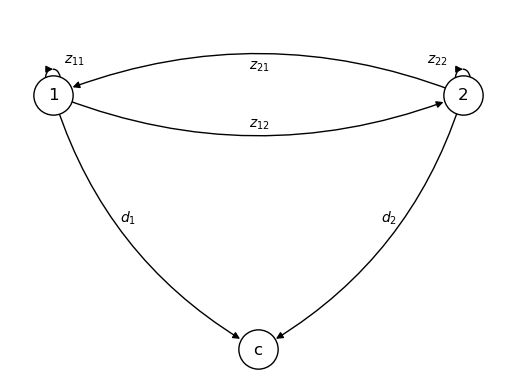

In [5]:
G = nx.DiGraph()

nodes= (1, 2, 'c')
edges = ((1, 1), (1, 2), (2, 1), (2, 2), (1, 'c'), (2, 'c'))
edges1 = ((1, 1), (1, 2), (2, 1), (2, 2), (1, 'c'))
edges2 = [(2,'c')]
G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos_list = ([0, 0], [2, 0], [1, -1])
pos = dict(zip(G.nodes(), pos_list))

fig, ax = plt.subplots()
plt.axis("off")

nx.draw_networkx_nodes(G, pos=pos, node_size=800,
                       node_color='white', edgecolors='black')
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G,pos=pos, edgelist=edges1,
                       node_size=300, connectionstyle='arc3,rad=0.2',
                       arrowsize=10, min_target_margin=15)
nx.draw_networkx_edges(G, pos=pos, edgelist=edges2,
                       node_size=300, connectionstyle='arc3,rad=-0.2',
                       arrowsize=10, min_target_margin=15)

plt.text(0.055, 0.125, r'$z_{11}$')
plt.text(1.825, 0.125, r'$z_{22}$')
plt.text(0.955, 0.1, r'$z_{21}$')
plt.text(0.955, -0.125, r'$z_{12}$')
plt.text(0.325, -0.5, r'$d_{1}$')
plt.text(1.6, -0.5, r'$d_{2}$')

plt.show()

*可行分配必须满足*

$$
\begin{aligned}
(1 - a_{11}) x_1 - a_{12} x_2 & \geq d_1 \cr
-a_{21} x_1 + (1 - a_{22}) x_2 & \geq d_2 \cr
a_{01} x_1 + a_{02} x_2 & \leq x_0
\end{aligned}
$$

这可以用图形表示如下。

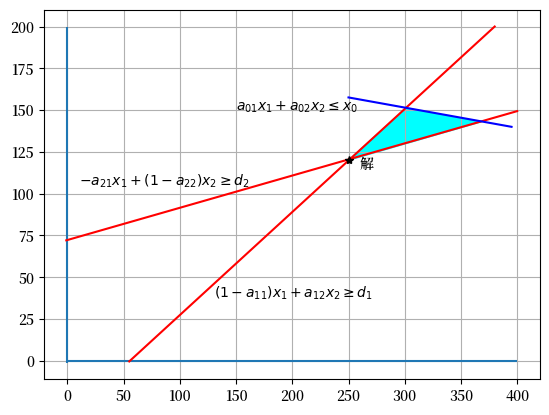

In [6]:
fig, ax = plt.subplots()
ax.grid()

# 绘制约束线
ax.hlines(0, -1, 400)
ax.vlines(0, -1, 200)

ax.plot(np.linspace(55, 380, 100), (50-0.9*np.linspace(55, 380, 100))/(-1.46), color="r")
ax.plot(np.linspace(-1, 400, 100), (60+0.16*np.linspace(-1, 400, 100))/0.83, color="r")
ax.plot(np.linspace(250, 395, 100), (62-0.04*np.linspace(250, 395, 100))/0.33, color="b")

ax.text(130, 38, "$(1-a_{11})x_1 + a_{12}x_2 \geq d_1$", size=10)
ax.text(10, 105, "$-a_{21}x_1 + (1-a_{22})x_2 \geq d_2$", size=10)
ax.text(150, 150, "$a_{01}x_1 +a_{02}x_2 \leq x_0$", size=10)

# 绘制可行区域
feasible_set = Polygon(np.array([[301, 151],
                                 [368, 143],
                                 [250, 120]]),
                       color="cyan")
ax.add_patch(feasible_set)

# 绘制最优解
ax.plot(250, 120, "*", color="black")
ax.text(260, 115, "解", size=10)

plt.show()

更一般地说，生产的约束条件是

$$
\begin{aligned}
(I - A) x &  \geq d \cr
a_0^\top x & \leq x_0
\end{aligned}
$$ (eq:inout_1)

其中 $A$ 是一个 $n \times n$ 的矩阵，其典型元素为 $a_{ij}$，而 $a_0^\top = \begin{bmatrix} a_{01} & \cdots & a_{0n} \end{bmatrix}$。

如果我们解 {eq}`eq:inout_1` 的第一组方程，得到总产出 $x$，我们得到

$$
x = (I -A)^{-1} d \equiv L d
$$ (eq:inout_2)

其中矩阵 $L = (I-A)^{-1}$ 有时被称为 **列昂惕夫逆矩阵**。

为确保 {eq}`eq:inout_2` 的解 $X$ 是一个正向量，以下 **霍金斯-西蒙条件** 就足够了：

$$
\begin{aligned}
\det (I - A) > 0 \text{ 且} \;\;\; \\
(I-A)_{ij} > 0 \text{ 对所有 } i=j
\end{aligned}
$$

```{prf:example}
:label: io_ex_tg

例如，一个由以下描述的两种商品经济

$$
A =
\begin{bmatrix}
    0.1 & 40 \\
    0.01 & 0
\end{bmatrix}
\text{ 和 }
d =
\begin{bmatrix}
    50 \\
    2
\end{bmatrix}
$$ (eq:inout_ex)
```

In [7]:
A = np.array([[0.1, 40],
             [0.01, 0]])
d = np.array([50, 2]).reshape((2, 1))

In [8]:
I = np.identity(2)
B = I - A
B

array([[ 9.e-01, -4.e+01],
       [-1.e-02,  1.e+00]])

让我们检查一下**霍金斯-西蒙条件**

In [9]:
np.linalg.det(B) > 0 # 检查霍金斯-西蒙条件

True

现在我们计算列昂惕夫逆矩阵

In [10]:
L = np.linalg.inv(B) # 得到列昂惕夫逆矩阵
L

array([[2.0e+00, 8.0e+01],
       [2.0e-02, 1.8e+00]])

In [11]:
x = L @ d   # 求解毛产出
x

array([[260. ],
       [  4.6]])

## 生产可能性边界

{eq}`eq:inout_1`的第二个等式可以写成

$$
a_0^\top x = x_0
$$

或

$$
A_0^\top d = x_0
$$ (eq:inout_frontier)

其中

$$
A_0^\top = a_0^\top (I - A)^{-1}
$$

对于 $i \in \{1, \ldots , n\}$，$A_0$ 的第 $i$ 个分量是生产一单位第 $i$ 种商品的最终产出所需的劳动量。

等式 {eq}`eq:inout_frontier` 描绘了一个**生产可能性边界**，表示在给定外生劳动投入 $x_0$ 的情况下，可以生产的最终消费束 $d$。

```{prf:example}
:label: io_ex_ppf

考虑{eq}`eq:inout_ex`中的例子。

假设我们现在给出

$$
a_0^\top = \begin{bmatrix}
4 & 100
\end{bmatrix}
$$
```

然后我们可以通过以下方式找到 $A_0^\top$：

In [12]:
a0 = np.array([4, 100])
A0 = a0 @ L
A0

array([ 10., 500.])

因此，这个经济体的生产可能性边界是：

$$
10d_1 + 500d_2 = x_0
$$

## 价格
{cite}`DoSSo` 认为，$n$ 种生产商品的相对价格必须满足

$$
\begin{aligned}
p_1 = a_{11}p_1 + a_{21}p_2 + a_{01}w \\
p_2 = a_{12}p_1 + a_{22}p_2 + a_{02}w
\end{aligned}
$$

更一般地，

$$
p = A^\top p + a_0 w
$$

这表明每种最终商品的价格等于生产的总成本，包括中间投入品的成本 $A^\top p$ 和劳动力成本 $a_0 w$。

这个方程可以写成

$$
(I - A^\top) p = a_0 w
$$ (eq:inout_price)

这意味着

$$
p = (I - A^\top)^{-1} a_0 w
$$

注意 {eq}`eq:inout_price` 与 {eq}`eq:inout_1` 通过相互转置的算子形成了一个**共轭对**。

这种联系在经典线性规划及其对偶问题中再次出现。

## 线性规划

**原始问题**是

$$
\min_{x} w a_0^\top x
$$

约束条件为

$$
(I - A) x \geq d
$$

相关的**对偶问题**是

$$
\max_{p} p^\top d
$$

约束条件为

$$
(I -A)^\top p \leq a_0 w
$$

原始问题选择一个可行的生产计划，以最小化交付预先指定的最终商品消费向量 $d$ 的成本。

对偶问题选择价格，以最大化预先指定的最终商品向量 $d$ 的价值，同时受制于价格覆盖生产成本。

根据[强对偶定理](https://en.wikipedia.org/wiki/Dual_linear_program#Strong_duality)，
原始问题和对偶问题的最优值相同：

$$
w a_0^\top x^* = p^* d
$$

其中 $^*$ 表示原始和对偶问题的最优选择。

对偶问题可以用图形表示如下。

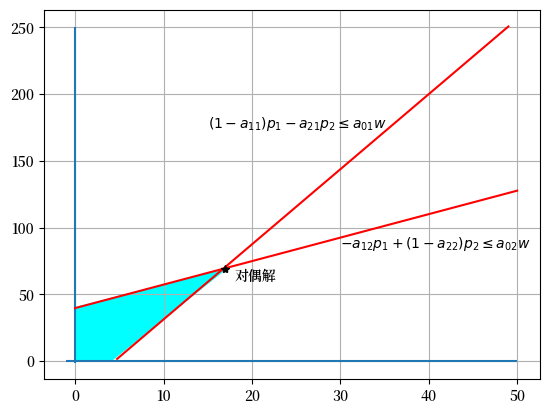

In [13]:
fig, ax = plt.subplots()
ax.grid()

# 绘制约束线
ax.hlines(0, -1, 50)
ax.vlines(0, -1, 250)

ax.plot(np.linspace(4.75, 49, 100), (4-0.9*np.linspace(4.75, 49, 100))/(-0.16), color="r")
ax.plot(np.linspace(0, 50, 100), (33+1.46*np.linspace(0, 50, 100))/0.83, color="r")

ax.text(15, 175, "$(1-a_{11})p_1 - a_{21}p_2 \leq a_{01}w$", size=10)
ax.text(30, 85, "$-a_{12}p_1 + (1-a_{22})p_2 \leq a_{02}w$", size=10)

# 绘制可行区域
feasible_set = Polygon(np.array([[17, 69],
                                 [4, 0],
                                 [0,0],
                                 [0, 40]]),
                       color="cyan")
ax.add_patch(feasible_set)

# 绘制最优解
ax.plot(17, 69, "*", color="black")
ax.text(18, 60, "对偶解", size=10)

plt.show()

## 列昂惕夫逆矩阵
我们已经讨论过，总产出 $x$ 由公式 {eq}`eq:inout_2` 给出，其中 $L$ 被称为列昂惕夫逆矩阵。
回顾 {doc}`诺伊曼级数引理 <eigen_II>`，它指出如果谱半径 $r(A)<1$，则 $L$ 存在。
事实上

$$
L = \sum_{i=0}^{\infty} A^i
$$

### 需求冲击
考虑需求冲击 $\Delta d$ 的影响，它将需求从 $d_0$ 转变为 $d_1 = d_0 + \Delta d$。
总产出从 $x_0 = Ld_0$ 转变为 $x_1 = Ld_1$。
如果 $r(A) < 1$，则存在解，且

$$
\Delta x = L \Delta d = \Delta d + A(\Delta d) + A^2 (\Delta d) + \cdots
$$

这说明 $L$ 的一个元素 $l_{ij}$ 显示了对商品 $j$ 的需求单位变化对部门 $i$ 的总影响。

## 图论的应用
我们可以通过 {doc}`图论 <networks>` 的应用进一步研究投入产出网络。
投入产出网络可以通过邻接矩阵 $A$ 诱导的加权有向图来表示。
节点集 $V = [n]$ 是部门列表，边集由以下给出：

$$
E = \{(i,j) \in V \times V : a_{ij}>0\}
$$

在 {numref}`us_15sectors` 中，权重由箭头的宽度表示，与相应的投入产出系数成正比。
现在我们可以使用中心性度量来对部门进行排序，并讨论它们相对于其他部门的重要性。

### 特征向量中心性
节点 $i$ 的特征向量中心性由以下公式衡量：

$$
\begin{aligned}
    e_i = \frac{1}{r(A)} \sum_{1 \leq j \leq n} a_{ij} e_j
\end{aligned}
$$

我们为 {numref}`us_15sectors` 中表示的部门绘制了基于枢纽的特征向量中心性条形图。

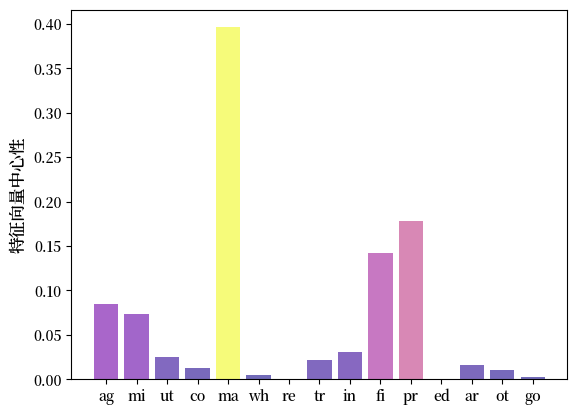

In [14]:
fig, ax = plt.subplots()
ax.bar(codes, centrality, color=color_list, alpha=0.6)
ax.set_ylabel("特征向量中心性", fontsize=12)
plt.show()

较高的指标表示作为供应商的重要性更高。
因此，大多数行业的需求冲击将显著影响具有高特征向量中心性的行业的活动。
上图表明制造业是美国经济中最主导的行业。

### 产出乘数
在投入产出网络中对行业进行排名的另一种方法是通过产出乘数。
行业 $j$ 的**产出乘数**，记为 $\mu_j$，通常定义为行业 $j$ 需求单位变化所产生的整个行业范围内的总影响。
早些时候在讨论需求冲击时，我们得出结论：对于 $L = (l_{ij})$，元素 $l_{ij}$ 表示行业 $j$ 需求单位变化对行业 $i$ 的影响。
因此，

$$
\mu_j = \sum_{j=1}^n l_{ij}
$$

这可以写成 $\mu^\top = \mathbb{1}^\top L$ 或

$$
\mu^\top = \mathbb{1}^\top (I-A)^{-1}
$$

请注意，这里我们用 $\mathbb{1}$ 表示一个全为1的向量。
在这个指标中排名较高的行业是中间品的重要购买者。
这些行业的需求冲击将对整个生产网络造成巨大影响。
下图显示了 {numref}`us_15sectors` 中表示的各行业的产出乘数。

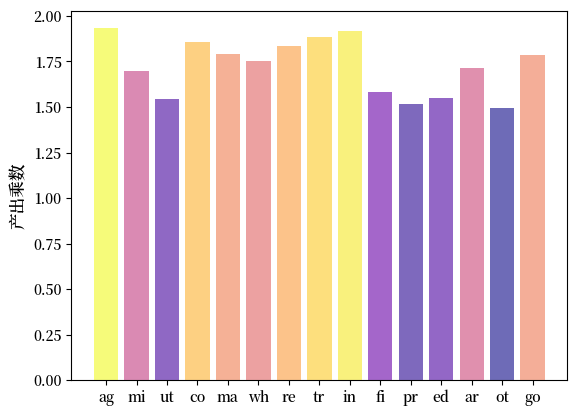

In [15]:
A, F = build_coefficient_matrices(Z, X)
omult = qbn_io.katz_centrality(A, authority=True)

fig, ax = plt.subplots()
omult_color_list = qbn_io.colorise_weights(omult,beta=False)
ax.bar(codes, omult, color=omult_color_list, alpha=0.6)
ax.set_ylabel("产出乘数", fontsize=12)
plt.show()

我们观察到制造业和农业是排名最高的行业。

## 练习

```{exercise-start}
:label: io_ex1
```

{cite}`DoSSo` 第9章讨论了一个具有以下参数设置的例子：

$$
A = \begin{bmatrix}
     0.1 & 1.46 \\
     0.16 & 0.17
    \end{bmatrix}
\text{ 和 }
a_0 = \begin{bmatrix} .04 & .33 \end{bmatrix}
$$

$$
x = \begin{bmatrix} 250 \\ 120 \end{bmatrix}
\text{ 和 }
x_0 = 50
$$

$$
d = \begin{bmatrix} 50 \\ 60 \end{bmatrix}
$$

描述他们如何从以下关于农业和制造业的假设"数据"中推断出A和a_0中的投入-产出系数：

$$
z = \begin{bmatrix} 25 & 175 \\
         40 &   20 \end{bmatrix}
\text{ 和 }
z_0 = \begin{bmatrix} 10 & 40 \end{bmatrix}
$$

其中z_0是每个行业使用的劳动服务的向量。
```{exercise-end}
```

```{solution-start} io_ex1
:class: dropdown
```
For each $i = 0,1,2$ and $j = 1,2$

$$
a_{ij} = \frac{z_{ij}}{x_j}
$$

```{solution-end}
```

```{exercise-start}
:label: io_ex2
```

推导上一练习中所描述经济的生产可能性边界。

```{exercise-end}
```

```{solution-start} io_ex2
:class: dropdown
```

In [16]:
A = np.array([[0.1, 1.46],
              [0.16, 0.17]])
a_0 = np.array([0.04, 0.33])

In [17]:
I = np.identity(2)
B = I - A
L = np.linalg.inv(B)

In [18]:
A_0 = a_0 @ L
A_0

array([0.16751071, 0.69224776])

因此，生产可能性边界由以下给出

$$
0.17 d_1 + 0.69 d_2 = 50
$$

```{solution-end}
```